# Car_Evaluation_Analysis

#### Using Machine Learning to Predict Vehicle Acceptability

In [1]:
# imports

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
RandomizedSearchCV,
cross_validate,
train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
import altair as alt

## Summary
we put all the possible classification classifer into a dictonary and found the RBF SVM classifier optimized using specific hyperparameters (C=100.0, gamma=0.1) became the best model. The average test accuracy was 0.952.On the 346 test data cases, it correctly predicted 343. It incorrectly predicted 3 cases, which were mostly false negative — 2 good cases predicted as acceptable. The model showed exceptional ability in determining the acceptability of automobiles as seen in the confusion matrix and classification reports. Classification was achieved for most categories with high precision, recall and F1 scores. The focus was on a slight decrease in classification precision for the “good” category. A recall of 0.86 indicates occasional classification errors. This comprehensive analysis emphasizes the ability of the RBF SVM to handle nonlinear decision boundaries. This makes it a solid choice for practical applications where reliable prediction is critical.




## Introduction
The Car EvaluationDataset is an essential tool for understanding the acceptability of automobiles based on a variety of attributes. These attributes include buying price, price of the maintenance, capacity and safety. The goal of this project is to develop a machine learning model that can effectively evaluate the quality of a car to help buyers make informed decisions.The RBF SVM model is known for its effectiveness in nonlinear classification tasks, and its use is particularly aimed at navigating the complexities of car evaluation. We expected the model to perform well. In our tests, we also found that it outperformed other models such as Naive Bayes and logistic regression. Our findings suggest a potential class imbalance or capacity limitation in the model's ability to adequately capture the nuances of the “good” classes. This raises questions about the ideal modeling approach for such datasets.

## Methods




#### Data

The dataset that was used in this project is of Car Evaluation Database created by the efforts of M. Bohanec and V. Rajkovic in the early 1990s. It was sourced from the UCI Machine Learning Repository and is publicly available for research and can be found here [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/19/car+evaluation).Each row in the dataset details a car’s attributes, including its buying price, maintenance cost, number of doors, capacity to seat persons, luggage boot size, and safety rating. 

In [6]:
# import raw data
# data located at https://archive.ics.uci.edu/dataset/19/car+evaluation

colnames = ['buying','maint','doors','persons','lug_boot','safety','class']
car_data = pd.read_csv('../data/raw/car.data', names=colnames, header=None)

car_data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [7]:
# train test split, export to csv
np.random.seed(522)

car_train, car_test = train_test_split(car_data, train_size = 0.8, random_state = 522, stratify=car_data['class'])
car_train.to_csv('../data/processed/car_train.csv')
car_test.to_csv('../data/processed/car_test.csv')

In [8]:
alt.Chart(car_train).mark_bar().encode(
    x=alt.X(alt.repeat('row')),
    y='count()',
    color=alt.Color('class'),
    column='class'
).repeat(
    row=['buying','maint','doors','persons','lug_boot','safety']
)

alt.RepeatChart(...)

#### Preprocessing

In [9]:
# preprocessing

# transform categorical features
car_preprocessor = make_column_transformer(
    (OrdinalEncoder(categories=[['low','med','high','vhigh']]), ['buying']),
    (OrdinalEncoder(categories=[['low','med','high','vhigh']]), ['maint']),
    (OrdinalEncoder(categories=[['2','3','4','5more']]), ['doors']),
    (OrdinalEncoder(categories=[['2','4','more']]), ['persons']),
    (OrdinalEncoder(categories=[['small','med','big']]), ['lug_boot']),
    (OrdinalEncoder(categories=[['low','med','high']]), ['safety']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

car_preprocessor.fit(car_train)
encoded_car_train = car_preprocessor.transform(car_train)
encoded_car_test = car_preprocessor.transform(car_test)

names = car_preprocessor.get_feature_names_out()
encoded_car_train = pd.DataFrame(encoded_car_train, columns=names)
encoded_car_test = pd.DataFrame(encoded_car_test, columns=names)

encoded_car_train.to_csv('../data/encoded_car_train.csv')
encoded_car_test.to_csv('../data/encoded_car_train.csv')

In [10]:
X_train, y_train = car_train.drop(columns=['class']), car_train['class']
X_test, y_test = car_test.drop(columns=['class']), car_test['class']

#### Analysising

Before we junp into analysising, we will have a plan on what we are going to do. Since we already have the X_train, y_train and X_test, y_test, the next step we need to choose the best classifier. First, lets put all the possible classification classifer into a dictonary.

In [11]:
models = {
    "dummy": DummyClassifier(random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123, max_depth=5),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=123)
}

Then, we need to apply cross_validation to all the models to find out the best one.

In [12]:
cv_results = []
for model_name, model in models.items():
    pipe = make_pipeline(car_preprocessor, model)
    scores = cross_validate(pipe, X_train, y_train, n_jobs=-1, return_train_score=True, cv=5)
    cv_results.append({
        "Model": model_name,
        "Mean Train Score": np.mean(scores['train_score']),
        "Std Train Score": np.std(scores['train_score']),
        "Mean Test Score": np.mean(scores['test_score']),
        "Std Test Score": np.std(scores['test_score'])
    })

cv_results_df = pd.DataFrame(cv_results)
cv_results_df


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}

According to our cross-validation result. We can see the test score and the train score. RBF SVM has the highest test score, suggesting it is the most accurate model for unseen data. Therefore, we will choose RBF SVM as our best model.

Next, we will find out the optimized hyperparameter for our model using random search

In [13]:
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-5, 5, 1),
    "svc__C": 10.0 ** np.arange(-5, 5, 1)
}
svc_pipe = make_pipeline(car_preprocessor, SVC(random_state=123))
random_search = RandomizedSearchCV(svc_pipe, param_distributions=param_grid, n_iter=100, n_jobs= -1, return_train_score=True) 
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder-1',
                                                                               OrdinalEncoder(categories=[['low',
                                                                                                           'med',
                                                                                                           'high',
                                                                                                           'vhigh']]),
                                                                               ['buying']),
                                                                              ('ordinalencoder-2',
                                                                               OrdinalEncoder(categories=[['low',
                                                                                                           'med',
                                                                                                           'high',
                                                                                                           'vhigh']]),
                                                                               ['maint']),
                                                                              ('ordinalencoder-3',
                                                                               OrdinalEncoder(categories=[['...
                                                                               OrdinalEncoder(categories=[['low',
                                                                                                           'med',
                                                                                                           'high']]),
                                                                               ['safety'])],
                                                                verbose_feature_names_out=False)),
                                             ('svc', SVC(random_state=123))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svc__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]),
                                        'svc__gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])},
                   return_train_score=True)

In [14]:
best_model = random_search.best_estimator_
best_model


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high',
                                                                              'vhigh']]),
                                                  ['buying']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high',
                                                                              'vhigh']]),
                                                  ['maint']),
                                                 ('ordinalencoder-3',
                                                  OrdinalEncoder(categories=[['2',
                                                                              '3',
                                                                              '4',
                                                                              '5more']]),
                                                  ['doors']),
                                                 ('ordinalencoder-4',
                                                  OrdinalEncoder(categories=[['2',
                                                                              '4',
                                                                              'more']]),
                                                  ['persons']),
                                                 ('ordinalencoder-5',
                                                  OrdinalEncoder(categories=[['small',
                                                                              'med',
                                                                              'big']]),
                                                  ['lug_boot']),
                                                 ('ordinalencoder-6',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high']]),
                                                  ['safety'])],
                                   verbose_feature_names_out=False)),
                ('svc', SVC(C=100.0, gamma=0.1, random_state=123))])


From the random search result, we have found out the best estimator(SVC(C=100.0, gamma=0.1, random_state=123)). Next, we will apply the best model on our test set.

In [15]:
best_model.fit(X_train, y_train)
print(classification_report(
        y_test, best_model.predict(X_test)
    ))

              precision    recall  f1-score   support

         acc       0.96      1.00      0.98        77
        good       1.00      0.86      0.92        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      1.00      1.00        13

    accuracy                           0.99       346
   macro avg       0.99      0.96      0.98       346
weighted avg       0.99      0.99      0.99       346



As the classification report has indicated, our model is extremely well, with very high score on precision, recall and f1-score. For the dominant classes (unacc and vgood), our model is achieving perfect scores. However, class "good" has the weakest recall (0.86), meaning some "good" samples are being misclassified, but the issue is minor given the high overall performance.

Next, we are going to create a Confusion Matrix Visualization to see how well our model is predicting correct or incorrect



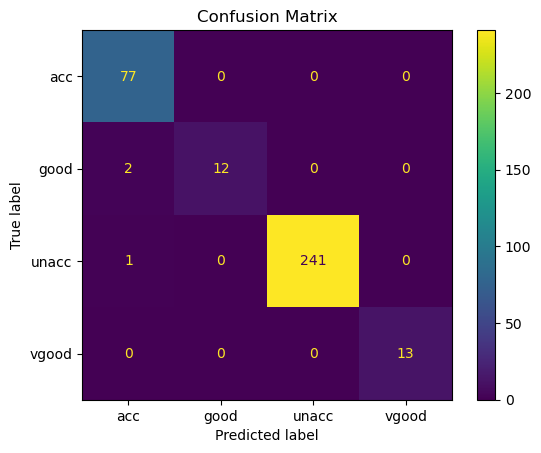

In [16]:
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
)
plt.title("Confusion Matrix")
plt.show()

We can see that the model performs well, with only 3 false predictions on our test data.

## Results & Discussion

After performing classification analysis, the RBF SVM model with optimized hyperparameters (C=100.0, gamma=0.1) achieved the best performance, with a mean test accuracy of 0.952. This suggests the model is highly effective at predicting the target classes. The confusion matrix and classification report showed nearly perfect precision, recall, and F1 scores across most classes. However, the "good" class had slightly lower recall (0.86), indicating some misclassifications.

We expect this model will be the best model, because RBF SVM performs well on nonlinear decision boundaries. However, we do not expect the model to perform that well because the features are not that high-dimensional, and the data does not sparse. But we still think it is the best among other models like naive Bayes and logistic regression.

With this finding, we can easily identify which cars are good and which are not for unseen data, making it suitable for deployment in a real-world system where reliable predictions are needed .

As I mentioned, SVMs absolutely are not the best model for this task, this brings out a question: Is there any better model than RBF SVM? Also we see the 'good' class has a low recall, does it mean there is a class imbalance in the data? Or does it just because the model is not the best model to pick.



## References